<a href="https://colab.research.google.com/github/jaysh23/jaysh23/blob/main/Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os

In [ ]:
data_dir = "/content/gdrive/MyDrive/PROJ/dataset".format(os.getcwd()) 

In [ ]:
data_dir

'/content/gdrive/MyDrive/PROJ/dataset'

In [ ]:
os.listdir(data_dir)

['LMW_RejectedImages', 'LMW_AcceptedImages']

In [ ]:
for cls in os.listdir(data_dir):
    print(cls, ':', len(os.listdir(data_dir + '/' + cls)))

LMW_RejectedImages : 102
LMW_AcceptedImages : 102


In [ ]:
from torchvision.datasets import ImageFolder 

In [ ]:
dataset = ImageFolder(data_dir)

In [ ]:
len(dataset)

204

In [ ]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=1280x1024 at 0x7F6AF0A1D590>, 0)

In [ ]:
dataset.classes

['LMW_AcceptedImages', 'LMW_RejectedImages']

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

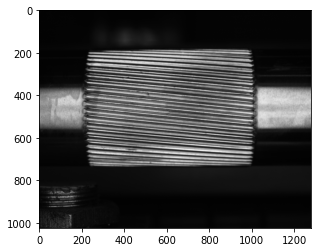

In [ ]:
img, label = dataset[203]
plt.imshow(img)

In [ ]:
import torchvision.transforms as tt

img_size = 224
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

dataset = ImageFolder(data_dir, tt.Compose([tt.Resize(img_size), 
                                            tt.RandomCrop(img_size),
                                            tt.ToTensor(),
                                            tt.Normalize(*imagenet_stats)]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


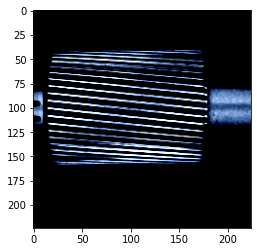

In [ ]:
img, label = dataset[2]
plt.imshow(img.permute((1, 2, 0)))

In [ ]:
val_pct = 0.3
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size

train_size, val_size

(143, 61)

In [ ]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader 

train_ds, valid_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(valid_ds)



batch_size = 64

train_dl = DataLoader(train_ds,
                      batch_size, 
                      shuffle=True,
                      num_workers=2,
                      pin_memory=True)

valid_dl = DataLoader(valid_ds,
                      batch_size,
                      num_workers=2,
                      pin_memory=True)

In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


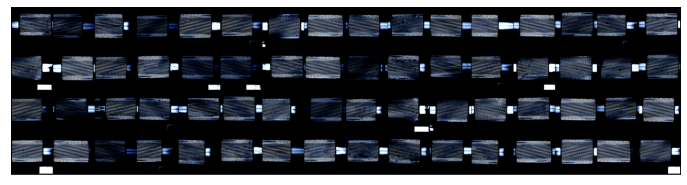

In [ ]:
show_batch(train_dl)

In [ ]:
'''train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)'''

NameError: ignored

In [ ]:
import torch

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
torch.cuda.is_available()

True

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
img, label = dataset[2]

In [ ]:
img.shape

torch.Size([3, 224, 224])

In [ ]:
img.device

device(type='cpu')

In [ ]:
img_gpu = to_device(img, device)
img_gpu.device

device(type='cuda', index=0)

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        #acc = accuracy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
from torchvision import models

class ResNet34(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=pretrained)
        # Replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

In [ ]:
model = to_device(ResNet34(len(dataset.classes), pretrained=True), device)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
model

ResNet34(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

In [ ]:
import torch
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
history = [evaluate(model, valid_dl)]
history

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[{'val_acc': 0.5409836173057556, 'val_loss': 0.8156422972679138}]

In [ ]:
history += fit_one_cycle(20, 0.001, model, train_dl, 
              valid_dl, weight_decay=0.01,
              grad_clip=0.1, opt_func=torch.optim.Adam)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [0], train_loss: 0.6715, val_loss: 0.8896, val_acc: 0.5410


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.3002, val_loss: 1.1210, val_acc: 0.5410


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.1603, val_loss: 1.2087, val_acc: 0.5738


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.2193, val_loss: 0.1034, val_acc: 0.9672


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.3220, val_loss: 0.2292, val_acc: 0.9180


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.5286, val_loss: 3.0837, val_acc: 0.4590


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.3905, val_loss: 52.7440, val_acc: 0.4590


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.1886, val_loss: 27.0202, val_acc: 0.4590


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.0985, val_loss: 19.1128, val_acc: 0.4590


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.0679, val_loss: 18.5880, val_acc: 0.4590


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [10], train_loss: 0.0545, val_loss: 13.3558, val_acc: 0.4590


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [11], train_loss: 0.0616, val_loss: 2.9738, val_acc: 0.5902


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [12], train_loss: 0.0654, val_loss: 0.1996, val_acc: 0.9836


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [13], train_loss: 0.1685, val_loss: 0.0470, val_acc: 0.9672


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [14], train_loss: 0.0535, val_loss: 0.2083, val_acc: 0.9180


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [15], train_loss: 0.1293, val_loss: 0.2940, val_acc: 0.9344


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [16], train_loss: 0.0857, val_loss: 0.1504, val_acc: 0.9508


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [17], train_loss: 0.0918, val_loss: 0.1314, val_acc: 0.9672


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [18], train_loss: 0.1365, val_loss: 0.0599, val_acc: 0.9672


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [19], train_loss: 0.0783, val_loss: 0.0574, val_acc: 0.9836


In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

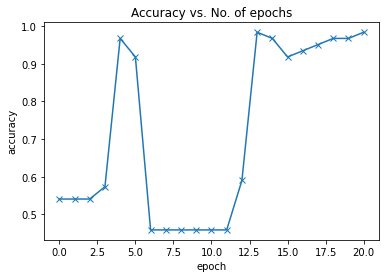

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

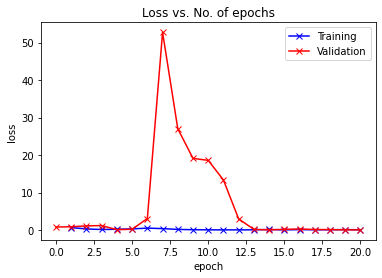

In [ ]:
plot_losses(history)

In [ ]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline

def denormalize(images, means, stds):
    if len(images.shape) == 3:
        images = images.unsqueeze(0)
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_image(img_tensor, label):
    print('Label:', dataset.classes[label], '(' + str(label) + ')')
    img_tensor = denormalize(img_tensor, *imagenet_stats)[0].permute((1, 2, 0))
    plt.imshow(img_tensor)

In [ ]:
def predict_image(img, model,classes):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return classes[preds[0].item()]

Label: LMW_RejectedImages (1)
Predicted LMW_RejectedImages


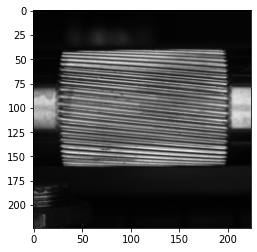

In [ ]:
img, label = valid_ds[2]
show_image(img, label)
pred = predict_image(img, model, dataset.classes)
print('Predicted', pred)

Label: LMW_AcceptedImages (0)
Predicted LMW_AcceptedImages


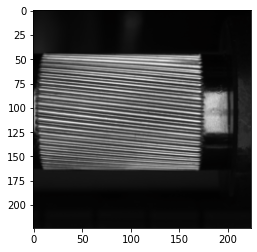

In [ ]:
img, label = valid_ds[1]
show_image(img, label)
pred = predict_image(img, model, dataset.classes)
print('Predicted', pred)

Label: LMW_AcceptedImages (0)
Predicted LMW_AcceptedImages


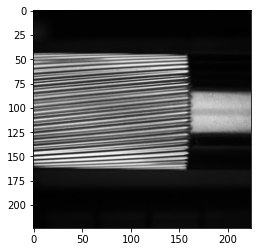

In [ ]:
img, label = valid_ds[0]
show_image(img, label)
pred = predict_image(img, model, dataset.classes)
print('Predicted', pred)

Label: LMW_RejectedImages (1)
Predicted LMW_RejectedImages


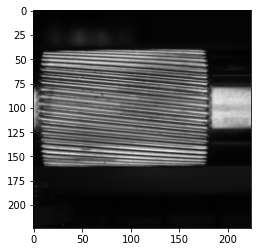

In [ ]:
img, label = valid_ds[2]
show_image(img, label)
pred = predict_image(img, model, dataset.classes)
print('Predicted', pred)

Label: LMW_AcceptedImages (0)
Predicted LMW_AcceptedImages


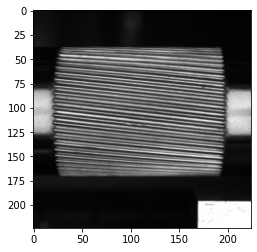

In [ ]:
img, label = valid_ds[5]
show_image(img, label)
pred = predict_image(img, model, dataset.classes)
print('Predicted', pred)

Label: LMW_RejectedImages (1)
Predicted LMW_RejectedImages


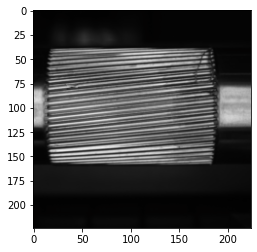

In [ ]:
img, label = valid_ds[7]
show_image(img, label)
pred = predict_image(img, model, dataset.classes)
print('Predicted', pred)